# <u>**Streaming Service Comparison**</u>

### **Objective:**
- Determine which streaming platform hosts the majority of content I enjoy so that I can pare down the services to which I subscribe. 

### **Data Sources:**
- [Netflix via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-netflix-dataset)
- [Hulu via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-hulu-dataset)
- [Prime via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-amazon-prime-dataset/data)
- [AppleTV via Kaggle.com](https://www.kaggle.com/datasets/octopusteam/full-apple-tv-dataset)

## **Data Collection & Loading**

### **Import Pandas, Numpy, Matplotlib, Wordcloud, and PIL**

In [1]:
import glob
import pandas as pd
import os
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

### **Data Load**

In [2]:
# Load in each file separately. 
apple = pd.read_csv("Data/AppleTV.csv")
hulu = pd.read_csv("Data/Hulu.csv")
netflix = pd.read_csv("Data/Netflix.csv")
prime = pd.read_csv("Data/Prime.csv")

### **Preliminary Review**

In [3]:
# View the head of each dataframe 
# Create a variable to include a list of all dataframes recently imported
dataframes = [apple, hulu, netflix, prime]
# Display only the head of each dataframe separately
for df in dataframes:
    display(df.head())

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
2,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
3,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN
4,Metropolis,movie,"Drama, Sci-Fi",1927.0,tt0017136,8.3,192628.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN
2,Finding Nemo,movie,"Adventure, Animation, Comedy",2003.0,tt0266543,8.2,1149529.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN
2,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,tt0266697,8.2,1238778.0,NaN
3,Jarhead,movie,"Biography, Drama, War",2005.0,tt0418763,7.0,214024.0,NaN
4,Unforgiven,movie,"Drama, Western",1992.0,tt0105695,8.2,449594.0,NaN


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN
2,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19686.0,NaN
3,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN
4,Citizen Kane,movie,"Drama, Mystery",1941.0,tt0033467,8.3,478085.0,NaN


In [4]:
# Get a sum of the total row count from each dataframe
total_rows = len(apple) + len(hulu) + len(netflix) + len(prime)
print(f"The total row count is {total_rows} for all dataframes.")

The total row count is 119711 for all dataframes.


### **Initial Insights**
- There are a total of 119,711 among all raw dataframes
- Each dataframe contains the same column headings
- None of the dataframes contain a column for the source of the dataframe
- All numerical columns appear to be floats and don't need to be
    - Change ***releaseYear*** and ***imdbNumVotes*** to integers
- The majority of the titles displayed contain multiple genres in the ***genres*** column
- The ***imdbId*** columns appear to match 
    - *American Beauty* in the 1st and 3rd dataframe
    - *Forest Gump* in the 1st, 2nd and 4th dataframes
- Of all the rows displayed, none include ***availableCountries*** data
    - Further information proves that this data point is not prevelent throughout the four dataframes


### **Preliminary Data Manipulation**

In [5]:
# Add a column to each dataframe to identify the data source since individually they do not have an identifier. 
# This is to ensure the data is discernable after the merge when duplicate content is present
apple["Service_Name"] = "AppleTV"
hulu["Service_Name"] = "Hulu"
netflix["Service_Name"] = "Netflix"
prime["Service_Name"] = "Prime"


# Using a previously made variable, created a for loop to run through each dataframe and display only the first two rows of each
# This is to ensure the column names and values were added propertly
for df in dataframes:
    display(df.head(2))

,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2354158.0,NaN,AppleTV


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Hulu
1,Shadows in Paradise,movie,"Comedy, Drama, Music",1986.0,tt0092149,7.5,7792.0,NaN,Hulu


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,American Beauty,movie,Drama,1999.0,tt0169547,8.3,1241156.0,NaN,Netflix
1,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,tt0119116,7.6,522699.0,NaN,Netflix


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries,Service_Name
0,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8991.0,NaN,Prime
1,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,113546.0,NaN,Prime


### **Data Merge**

In [6]:
# Merge the dataframes together into one by appending them to the end of each other since they are all using the same column names
streaming_v1 = pd.concat([apple, hulu, netflix, prime], axis = 0)

# Based on above initial review, check to ensure there are a total of 119,711 rows in the new dataframe
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   title               116151 non-null  object 
 1   type                119711 non-null  object 
 2   genres              116226 non-null  object 
 3   releaseYear         119419 non-null  float64
 4   imdbId              109192 non-null  object 
 5   imdbAverageRating   105942 non-null  float64
 6   imdbNumVotes        105942 non-null  float64
 7   availableCountries  651 non-null     object 
 8   Service_Name        119711 non-null  object 
dtypes: float64(3), object(6)
memory usage: 9.1+ MB


### **Data Cleaning & Preparation**

In [7]:
# Drop the availableCountries column given that less than 1% (0.0054%) of entries utilize this data element
streaming_v1.drop("availableCountries", axis = 1, inplace=True)

# Display only the columns to ensure the dropped column is gone
streaming_v1.columns

Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'Service_Name'],
      dtype='object')

In [8]:
# Rename the columns 
streaming_v1.rename(columns={"title":"Title","type":"Content_Type","genres":"Combined_Genres","releaseYear":"Release_Year","imdbId":"IMDb_ID","imdbAverageRating":"IMDb_Avg_Rating","imdbNumVotes":"IMDb_Votes_Count"},inplace = True)
streaming_v1.columns


Index(['Title', 'Content_Type', 'Combined_Genres', 'Release_Year', 'IMDb_ID',
       'IMDb_Avg_Rating', 'IMDb_Votes_Count', 'Service_Name'],
      dtype='object')

In [9]:
# Change Release_Year, IMDb_Votes_Counts from floats to integers 
streaming_v1[["Release_Year","IMDb_Votes_Count"]] = streaming_v1[["Release_Year","IMDb_Votes_Count"]].apply(np.int64)
# Change Service_Name & Combined_Genres to string
streaming_v1[["Service_Name","Combined_Genres"]] == streaming_v1[["Service_Name","Combined_Genres"]].astype(str)

# Display only the data types to ensure the data types were changed
streaming_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119711 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      119711 non-null  object 
 2   Combined_Genres   116226 non-null  object 
 3   Release_Year      119711 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  119711 non-null  int64  
 7   Service_Name      119711 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.2+ MB


c:\Users\rkynhoff\OneDrive - University of Rochester\Documents\CodeLouisville\Streaming_Service_Comparisons\venv\Lib\site-packages\pandas\core\series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [10]:
# Determine how many titles contain null values
print("There are",streaming_v1["Title"].isna().sum(),"rows with null values in the Title column.")

There are 3560 rows with null values in the Title column.


In [11]:
# Drop the rows containing null values in the Title column
streaming_v1 = streaming_v1.dropna(subset=["Title"])

# Ensure duplicate rows were dropped
streaming_v1.info()

# Can see in the results that the total entries went from 119,711 to 116,151, a drop of 3,560 rows


<class 'pandas.core.frame.DataFrame'>
Index: 116151 entries, 0 to 70293
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116151 non-null  object 
 1   Content_Type      116151 non-null  object 
 2   Combined_Genres   113936 non-null  object 
 3   Release_Year      116151 non-null  int64  
 4   IMDb_ID           109192 non-null  object 
 5   IMDb_Avg_Rating   105942 non-null  float64
 6   IMDb_Votes_Count  116151 non-null  int64  
 7   Service_Name      116151 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 8.0+ MB


In [12]:
# Determine how many duplicated rows exist
print("There are", streaming_v1.duplicated().sum(),"duplicated rows.")

There are 8 duplicated rows.


In [13]:
# Taking a look at the duplicated rows since there are so few & sort by title alphabetically with the default ascending
streaming_v1[streaming_v1.duplicated(keep=False)].sort_values("Title")

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
3486,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
13979,A Personal Journey with Martin Scorsese Throug...,movie,"Biography, Documentary, History",1995,tt0112120,8.5,5201,AppleTV
36061,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
45434,Belle,movie,"Fantasy, Horror",2023,tt12373754,5.4,169,Prime
25222,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
42998,Burn,movie,NaN,2014,NaN,NaN,-9223372036854775808,Prime
50643,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
51439,Flower Boy,movie,NaN,2021,NaN,NaN,-9223372036854775808,Prime
7245,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu
7246,Scorned: Love Kills,tv,"Crime, Documentary",2012,tt2287041,6.9,304,Hulu


In [14]:
# Since the rows do appear to be fully dupliated, I will drop the duplicate rows here
streaming_v2 = streaming_v1.drop_duplicates()

# Reset the index
streaming_v2 = streaming_v2.reset_index(drop=True)

# View total of entires, which should equal 116143 (116151  - 8)
streaming_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116143 entries, 0 to 116142
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             116143 non-null  object 
 1   Content_Type      116143 non-null  object 
 2   Combined_Genres   113930 non-null  object 
 3   Release_Year      116143 non-null  int64  
 4   IMDb_ID           109187 non-null  object 
 5   IMDb_Avg_Rating   105937 non-null  float64
 6   IMDb_Votes_Count  116143 non-null  int64  
 7   Service_Name      116143 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 7.1+ MB


In [15]:
# Determine how man rows include null values for Combined_Genres
print("There are",streaming_v1["Combined_Genres"].isna().sum(),"rows with null values in the Combined_Genres column.")

There are 2215 rows with null values in the Combined_Genres column.


In [16]:
# View the rows with null values for Combined_Genres
# May need to address this later
streaming_v1.loc[streaming_v1["Combined_Genres"].isnull()]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
2008,Anthappuram,movie,NaN,1980,tt0315778,5.6,7,AppleTV
3011,Siste trikk,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3082,Breathe without Water,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3088,El Arte De La Guerra,movie,NaN,2024,NaN,NaN,-9223372036854775808,AppleTV
3499,Atze Schröder - Revolution,movie,NaN,2010,NaN,NaN,-9223372036854775808,AppleTV
...,...,...,...,...,...,...,...,...
68120,Shea-suru ra! Instanto râmen arenji bu hajimem...,tv,NaN,2022,tt19408810,NaN,-9223372036854775808,Prime
68697,Secrets of the Exhibit,tv,NaN,2015,tt14546892,NaN,-9223372036854775808,Prime
68964,Hee!Hee!Hoo!,tv,NaN,2023,tt27010738,NaN,-9223372036854775808,Prime
69551,Kusuburi onna to sundome onna,tv,NaN,2023,tt29471798,NaN,-9223372036854775808,Prime


In [17]:
# Now that duplicated rows are gone, I want to see if there might be duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name
streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
38236,Amr's in Trouble,movie,"Romance, Comedy",2019,NaN,NaN,-9223372036854775808,Netflix
41702,Amr's in Trouble,movie,NaN,2019,NaN,NaN,-9223372036854775808,Netflix
93066,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
92157,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13328,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13557,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42322,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
42627,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
105044,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
106211,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime


In [18]:
# Based on the output above, I can see there is duplicated content and rows where genres could be combined into one row for each Service_Name

# Remove the duplicated rows that have a null value in the Combined_Genres column by index number
streaming_v3 = streaming_v2.drop([41702,12177,37721,89252,108129,108076,40887,102086,107404])
# Reset index
streaming_v3 = streaming_v3.reset_index(drop=True)
# Double check
streaming_v3[streaming_v3["Title"] == "The Final Ride"]


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [19]:
# Redisplay the duplicated content baesd on IMDb_ID, Release_Year, Title, Content_Type, and Service Name

grouped_dupes = streaming_v3[streaming_v3.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
grouped_dupes

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
93061,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
92152,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
13327,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13556,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
42623,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
105038,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
106205,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime


In [20]:
# See AI_Notes.docx for more information on how this code block came about
# Initialize an empty dictionary in which to store concatenated genres
concatenated_genres = {}

# Iterate over each row in the grouped_dupes dataframe
for index, row in grouped_dupes.iterrows():
    # Createa a unique key for each row in the grouped_dupes dataframe by combining certain columns
    key = (row["Title"], row["Content_Type"],row["Release_Year"], row["IMDb_ID"], row["IMDb_Votes_Count"], row["Service_Name"])
    # Checks if the key exists in the concatenated_genres dictionary & if so, append the new genres from the currnt row to the existing list of genres in the dictionary with a comma and space after each
    if key in concatenated_genres:
        concatenated_genres[key] += row["Combined_Genres"] + ', '
    # If the key doesn't exist in the dictionary, create a new entry in the dictionary with the combined genres from the current row, with a comma and a space
    else:
        concatenated_genres[key] = row["Combined_Genres"] + ', '

# Iniitialize a list to 
result_data = []
# Iterate over each key-value pair in the concatenated_genres dictionary
for key, genres in concatenated_genres.items():
    # Append a new list to the result_data list which contains the key values and the genres with the trailing comma and space removed
    result_data.append([key[0], key[1], genres[:-2], key[2], key[3], key[4], key[5]])

# Create a new dataframe from the result_data list with specified column names
result_df = pd.DataFrame(result_data, columns = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Votes_Count","Service_Name"])
# Create a new column in the new dataframe and assign the value of "none"
# This was done because each time I attempted to add the IMDb_Avg_Rating column to the key list above, the code would fail because it is an integer column in the original dataframe
result_df["IMDb_Avg_Rating"] = "None"
# Define a list of columns in the order in which I want them in the new dataframe
column_titles = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","IMDb_Avg_Rating","IMDb_Votes_Count","Service_Name"]
# reorder the columns in the new dataframe to match the specified order in the above code line
result_df = result_df.reindex(columns=column_titles)
# Display the new dataframe
display(result_df)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime
1,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,AppleTV
2,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Netflix
3,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime
5,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime
8,When life gives you lemons,movie,"Animation, Music",2024,NaN,None,-9223372036854775808,Prime


In [21]:
# Append the newly created dataframe to the previous dataframe
streaming_v4 = pd.concat([streaming_v3,result_df], axis = 0)

# Reset the indeces
streaming_v4.reset_index(drop=True) 

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV
2,American Beauty,movie,Drama,1999,tt0169547,8.3,1241156,AppleTV
3,Citizen Kane,movie,"Drama, Mystery",1941,tt0033467,8.3,478085,AppleTV
4,Metropolis,movie,"Drama, Sci-Fi",1927,tt0017136,8.3,192628,AppleTV
...,...,...,...,...,...,...,...,...
116138,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime
116139,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime
116140,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime
116141,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime


In [22]:
# Check to ensure that one of the titles with a duplicate row matching title, content_type, release_year, and service_name, but with a null value is Genres is present with the correct combined genres
streaming_v4[streaming_v4["Title"] == "The Final Ride"]

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
87483,The Final Ride,movie,"Comedy, Horror",2019,tt9869668,5.4,83,Prime
103850,The Final Ride,movie,"Crime, Action",2021,NaN,NaN,-9223372036854775808,Prime


In [23]:
display(streaming_v4[streaming_v4["Title"] == "Aurora"])
display(streaming_v4[streaming_v4["Title"] == "De olhos abertos"]) 
display(streaming_v4[streaming_v4["Title"] == "Fences"])
display(streaming_v4[streaming_v4["Title"] == "Imago"])
display(streaming_v4[streaming_v4["Title"] == "Fences"])
display(streaming_v4[streaming_v4["Title"] == "Leonardo: The Man Who Saved Science"])
display(streaming_v4[streaming_v4["Title"] == "Stealing Chaplin"])
display(streaming_v4[streaming_v4["Title"] == "When life gives you lemons"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
10284,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV
36433,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,729,Netflix
86916,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1893,Prime
90079,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime
92152,Aurora,movie,Horror,2019,NaN,NaN,-9223372036854775808,Prime
93061,Aurora,movie,Animation,2019,NaN,NaN,-9223372036854775808,Prime
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
13327,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,AppleTV
13556,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,AppleTV
42318,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Netflix
42623,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Netflix
105038,De olhos abertos,movie,Animation,2023,NaN,NaN,-9223372036854775808,Prime
106205,De olhos abertos,movie,"Drama, War",2023,NaN,NaN,-9223372036854775808,Prime
1,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,AppleTV
2,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Netflix
3,De olhos abertos,movie,"Animation, Drama, War",2023,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
7898,Fences,movie,Drama,2016,tt2671706,7.2,121120,AppleTV
13577,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,AppleTV
42659,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Netflix
77214,Fences,movie,Drama,2016,tt2671706,7.2,121120,Prime
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
105665,Imago,movie,"Drama, Thriller",2024,NaN,NaN,-9223372036854775808,Prime
108035,Imago,movie,Horror,2024,NaN,NaN,-9223372036854775808,Prime
5,Imago,movie,"Drama, Thriller, Horror",2024,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
7898,Fences,movie,Drama,2016,tt2671706,7.2,121120,AppleTV
13577,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,AppleTV
42659,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Netflix
77214,Fences,movie,Drama,2016,tt2671706,7.2,121120,Prime
103994,Fences,movie,Documentary,2023,NaN,NaN,-9223372036854775808,Prime
106324,Fences,movie,"Comedy, Drama",2023,NaN,NaN,-9223372036854775808,Prime
4,Fences,movie,"Comedy, Drama, Documentary",2023,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
82038,Leonardo: The Man Who Saved Science,movie,"Documentary, History, War",2017,tt6764348,7.0,72,Prime
93553,Leonardo: The Man Who Saved Science,movie,"Documentary, History, TV Movie",2017,NaN,NaN,-9223372036854775808,Prime
96736,Leonardo: The Man Who Saved Science,movie,"Documentary, History",2017,NaN,NaN,-9223372036854775808,Prime
6,Leonardo: The Man Who Saved Science,movie,"Documentary, History, Documentary, History, TV...",2017,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
94012,Stealing Chaplin,movie,Drama,2020,tt10205046,4.8,148,Prime
107192,Stealing Chaplin,movie,"Drama, Comedy, History",2024,NaN,NaN,-9223372036854775808,Prime
107203,Stealing Chaplin,movie,Comedy,2024,NaN,NaN,-9223372036854775808,Prime
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime


,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
56996,When life gives you lemons,movie,Music,2024,NaN,NaN,-9223372036854775808,Prime
107581,When life gives you lemons,movie,Animation,2024,NaN,NaN,-9223372036854775808,Prime
8,When life gives you lemons,movie,"Animation, Music",2024,NaN,None,-9223372036854775808,Prime


In [24]:
# streaming_v2[streaming_v2.duplicated(subset = ["IMDb_ID","Title","Release_Year","Content_Type","Service_Name"], keep = False)].sort_values(by=["Title","Service_Name","Combined_Genres"], ascending=[True,True,True])
streaming_v5 = streaming_v4.drop([92152,93061,13327,13556,42318,42623,105038,106205,103994,106324,105665,108035,93553,96736,107192,107203,56996,107581])

In [25]:
# Checking for the subset duplicates again
streaming_v5[streaming_v5.duplicated(subset = ["Title","Content_Type","Combined_Genres","Release_Year","IMDb_ID","Service_Name"], keep = False)].sort_values(by=["Title","Combined_Genres","Service_Name"], ascending=[True,True,True]).sort_index()

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name


In [26]:
# Checking a specific title to ensure of dropped rows
display(streaming_v5[streaming_v5["Title"] == "Aurora"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
10284,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,AppleTV
36433,Aurora,movie,"Horror, Thriller",2018,tt8821182,4.4,729,Netflix
86916,Aurora,movie,"Comedy, Drama, Romance",2019,tt8553606,6.7,1893,Prime
90079,Aurora,movie,Drama,2017,NaN,NaN,-9223372036854775808,Prime
0,Aurora,movie,"Animation, Horror",2019,NaN,None,-9223372036854775808,Prime


In [27]:
streaming_v5.dtypes

Title               object
Content_Type        object
Combined_Genres     object
Release_Year         int64
IMDb_ID             object
IMDb_Avg_Rating     object
IMDb_Votes_Count     int64
Service_Name        object
dtype: object

In [28]:
# An attempt to remove the duplicated Genre values in the Combined_Genres column prior to splitting the values into separate columns
# def remove_duped_combined_genres(Combined_Genres):
#     genres = Combined_Genres.str.split()
#     unique_comb_genres = list(dict.fromkeys(genres))
#     return ' '.join(unique_comb_genres)

# streaming_v5["Combined_Genres"] = streaming_v5["Combined_Genres"].apply(remove_duped_combined_genres)

In [29]:
# Second attempt to remove the duplicated Genre values in the Combined_Genres column prior to splitting the values into separate columns
# streaming_v5["Combined_Genres"] = streaming_v5["Combined_Genres"].apply(lambda x: ' '.join(set(x.split())))

In [30]:
# Still seeing the duplicated word "Comedy" in the COmbined_Genres column
display(streaming_v5[streaming_v5["Title"] == "Stealing Chaplin"])

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name
94012,Stealing Chaplin,movie,Drama,2020,tt10205046,4.8,148,Prime
7,Stealing Chaplin,movie,"Comedy, Drama, Comedy, History",2024,NaN,None,-9223372036854775808,Prime


In [31]:
streaming_v5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116125 entries, 0 to 8
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             116125 non-null  object
 1   Content_Type      116125 non-null  object
 2   Combined_Genres   113921 non-null  object
 3   Release_Year      116125 non-null  int64 
 4   IMDb_ID           109187 non-null  object
 5   IMDb_Avg_Rating   105946 non-null  object
 6   IMDb_Votes_Count  116125 non-null  int64 
 7   Service_Name      116125 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.0+ MB


In [32]:
#Obtain max number of elements in the Genres column
# streaming_v4["Combined_Genres"].str.split(", ",expand=True)


In [33]:
# Split the elements in the Genres column while creating new columns for the max number 
streaming_v5[["Genre_1","Genre_2","Genre_3","Genre_4","Genre_5","Genre_6","Genre_7"]] = streaming_v5["Combined_Genres"].str.split(',',expand=True)

streaming_v5.head(2)

,Title,Content_Type,Combined_Genres,Release_Year,IMDb_ID,IMDb_Avg_Rating,IMDb_Votes_Count,Service_Name,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7
0,Four Rooms,movie,Comedy,1995,tt0113101,6.7,113546,AppleTV,Comedy,None,None,None,None,None,None
1,Forrest Gump,movie,"Drama, Romance",1994,tt0109830,8.8,2354158,AppleTV,Drama,Romance,None,None,None,None,None


In [34]:
# Creating clean dataframe
streaming_clean = streaming_v5

### **Begin Analysis**

In [35]:
streaming_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116125 entries, 0 to 8
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Title             116125 non-null  object
 1   Content_Type      116125 non-null  object
 2   Combined_Genres   113921 non-null  object
 3   Release_Year      116125 non-null  int64 
 4   IMDb_ID           109187 non-null  object
 5   IMDb_Avg_Rating   105946 non-null  object
 6   IMDb_Votes_Count  116125 non-null  int64 
 7   Service_Name      116125 non-null  object
 8   Genre_1           113921 non-null  object
 9   Genre_2           75979 non-null   object
 10  Genre_3           44387 non-null   object
 11  Genre_4           117 non-null     object
 12  Genre_5           27 non-null      object
 13  Genre_6           3 non-null       object
 14  Genre_7           1 non-null       object
dtypes: int64(2), object(13)
memory usage: 14.2+ MB


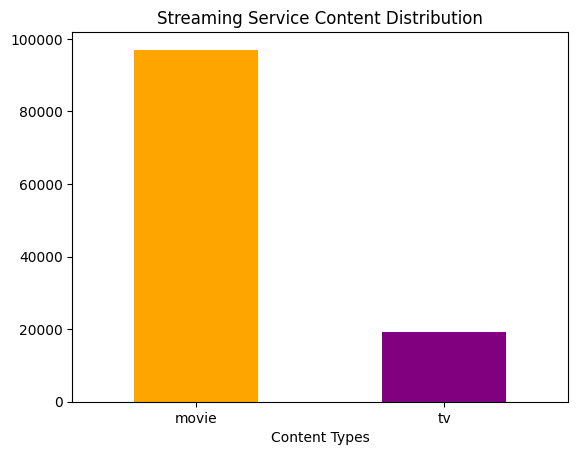

In [ ]:
# Crate a bar graph to show distribution of content types from the Content_Type column
# Plot it with orange for "movies" and purple for "tv"
streaming_clean["Content_Type"].value_counts().plot(kind='bar',color=["orange","purple"])
# Add a plot title
plt.title("Streaming Service Content Distribution")
# Change the orientation of the x ticks
plt.xticks(rotation = 360)
# Relable the X axis
plt.xlabel("Content Types")
# Show the bar graph 
plt.show()


<Axes: xlabel='Service_Name', ylabel='count'>

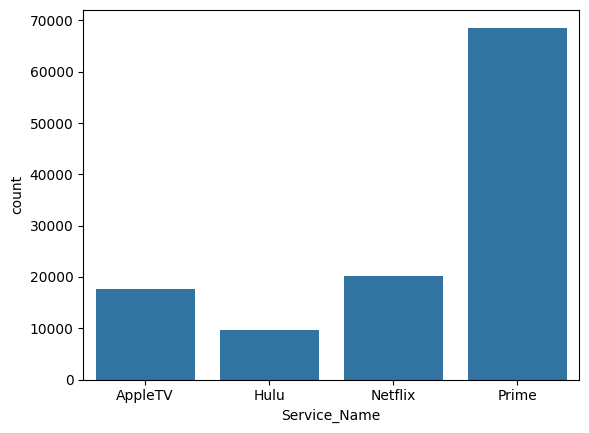

In [37]:
# Plotting which streaming platform contains the most content
sn.countplot(streaming_clean, x="Service_Name")

<Axes: xlabel='Service_Name', ylabel='count'>

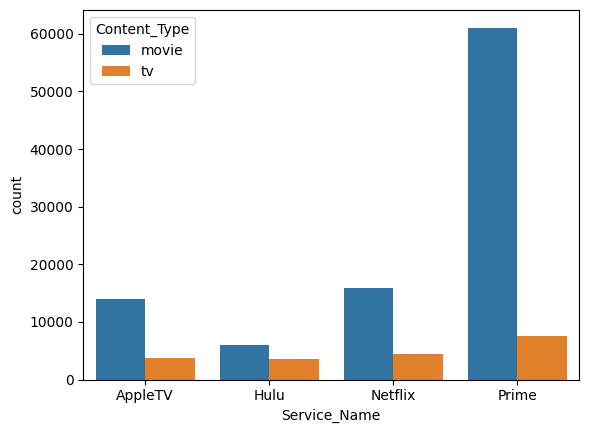

In [38]:
# Counts of the content type by streaming sesrvice
sn.countplot(streaming_clean,x="Service_Name", hue="Content_Type")